Instructions: click restart and run all above. Figures will show once the entire notebook has finished running

In [1]:
import sys
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

# Defining and solving ODE models

This notebook will demonstrate how we can define and solve an ODE model.

## scipy.integrate.odeint

We can solve ODEs using odeint from scipy.integrate:

In [2]:
from scipy.integrate import odeint

This takes an ODE function, initial conditions, and a sequence of timepoints as inputs. These must be defined for the problem at hand. I demonstrate this below for the Goehring et al., 2011 model

## Building an ODE model

The primary input of odeint is a ODE model function, which defines the reactions in the model. This must take two arguments: X, representing the current state of the system, and t representing the current time (if there is no time-dependence of the reactions then t will not be used but must be specified anyway). X must take the form of a list, where each entry in the list is a float representing the concentration of one species. This can be any length, depending on how many species there are in the model. The function must then return a list of the same length representing the derivative of X at t (dXdt). Here, as we have two species (A and P), X and dXdt will be lists of length 2

As this particular model contains many parameters, it is useful to build it in class form, specifying parameter values in the init function. This is demonstrated below for the Goehring model, where the function dxdt is built to describe all of the different reactions in the model.

In [3]:
class Goehring2011:
    def __init__(self, konA=0.00858, koffA=0.0054, konP=0.0474, koffP=0.0073, kPA=2, kAP=0.19,
                 alpha=1, beta=2, psi=0.174, pA=1.56, pP=1):
        self.konA = konA
        self.koffA = koffA
        self.konP = konP
        self.koffP = koffP
        self.alpha = alpha
        self.beta = beta
        self.psi = psi
        self.pA = pA
        self.pP = pP
        self.kAP = kAP
        self.kPA = kPA

    def dxdt(self, X, t):
        A = X[0]
        P = X[1]
        Acyt = self.pA - self.psi * A
        Pcyt = self.pP - self.psi * P
        dA = (self.konA * Acyt) - (self.koffA * A) - (self.kAP * (P ** self.alpha) * A)
        dP = (self.konP * Pcyt) - (self.koffP * P) - (self.kPA * (A ** self.beta) * P)
        return [dA, dP]
    
model = Goehring2011()

## Run ODE simulation

We can simulate this model easily with odeint. We need to specify a starting condition - we will start this model in an aPAR dominant state (all aPAR on the membrane, all pPAR in the cytoplasm), and run for 10000 seconds. As we can see from the figure, the system eventually stabilises to a different aPAR dominant state (A >> P). This, of course, will depend on parameters and the starting conditions.

<IPython.core.display.Javascript object>


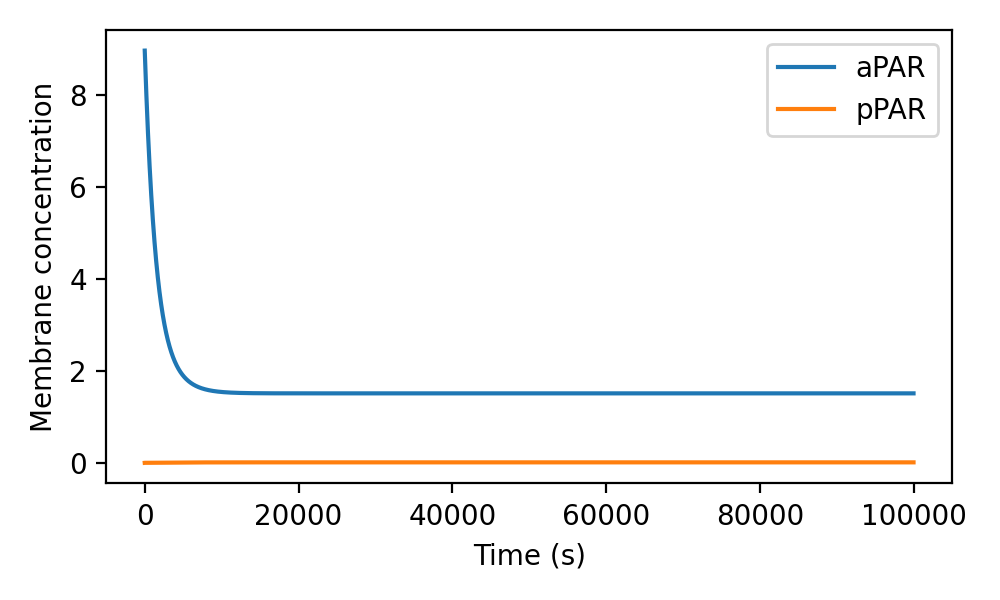

In [12]:
sol = odeint(model.dxdt, (model.pA / model.psi, 0), t=np.linspace(0, 10000, 100000))

fig, ax = plt.subplots()
ax.plot(sol[:, 0], label='aPAR')
ax.plot(sol[:, 1], label='pPAR')
ax.legend()
ax.set_xlabel('Time (s)')
ax.set_ylabel('Membrane concentration')
fig.set_size_inches(5,3)
fig.tight_layout()

## Testing for bistability

We can easily demonstrate that this model is biistable by performing two simulations, starting from extremely different starting conditions. sol1 represents the solution when starting from an aPAR dominant state (identical to above), sol2 represents the solutions when starting from a pPAR dominant state. As we can see, these two models settle to different final states, indicating bistability.

<IPython.core.display.Javascript object>


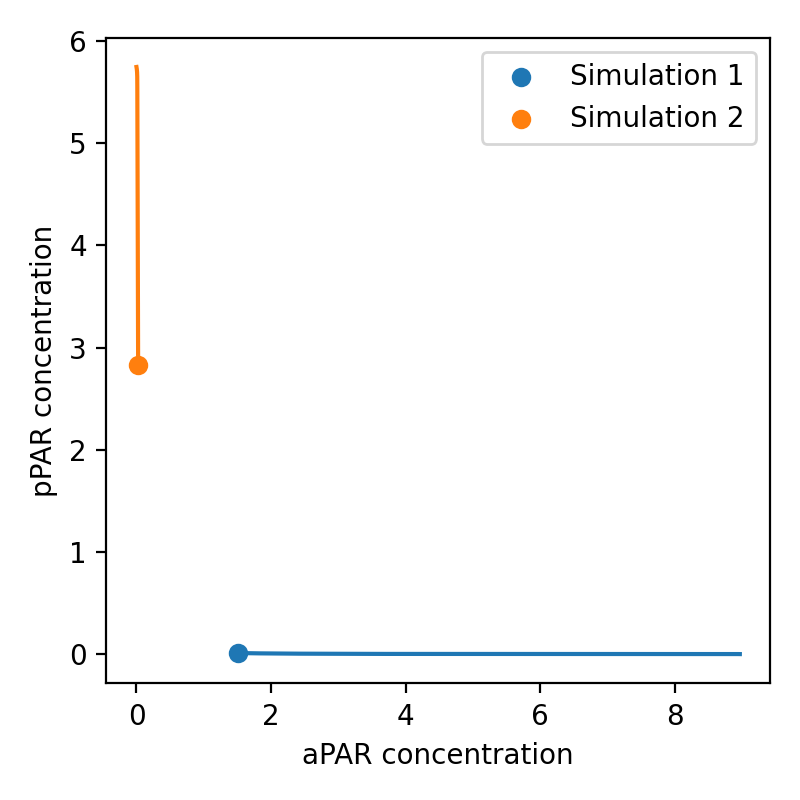

In [10]:
sol1 = odeint(model.dxdt, (model.pA / model.psi, 0), t=np.linspace(0, 10000, 100000))
sol2 = odeint(model.dxdt, (0, model.pP / model.psi), t=np.linspace(0, 10000, 100000))

fig, ax = plt.subplots()
ax.scatter(sol1[-1, 0], sol1[-1, 1], label='Simulation 1')
ax.scatter(sol2[-1, 0], sol2[-1, 1], label='Simulation 2')
ax.plot(sol1[:, 0], sol1[:, 1])
ax.plot(sol2[:, 0], sol2[:, 1])
ax.legend()
ax.set_xlabel('aPAR concentration')
ax.set_ylabel('pPAR concentration')
fig.set_size_inches(4, 4)
fig.tight_layout()

## Testing for linear instability

We can test the linear stabilty of any stable states by calculating a numerical approximation of the jacobian at that point. This method is demonstrated by the function below, which approximates the relevant derivatives of the jacobian with a finite difference method:

In [6]:
class Goehring2011_jacobian:
    def __init__(self, konA=0.00858, koffA=0.0054, konP=0.0474, koffP=0.0073, kPA=2, kAP=0.19,
                 alpha=1, beta=2, psi=0.174, pA=1.56, pP=1):
        self.konA = konA
        self.koffA = koffA
        self.konP = konP
        self.koffP = koffP
        self.alpha = alpha
        self.beta = beta
        self.psi = psi
        self.pA = pA
        self.pP = pP
        self.kAP = kAP
        self.kPA = kPA

    def jacobian(self, X, step=0.0001):
        A = X[0]
        P = X[1]
        Acyt = self.pA - self.psi * A
        Pcyt = self.pP - self.psi * P
        dPdA = (self.konP * Pcyt) - (self.koffP * P) - (self.kPA * ((A + step) ** self.beta) * P) 
        dAdP = (self.konA * Acyt) - (self.koffA * A) - (self.kAP * ((P + step) ** self.alpha) * A) 
        dAdA = (self.konA * Acyt) - (self.koffA * (A + step)) - (self.kAP * (P ** self.alpha) * (A + step))
        dPdP = (self.konP * Pcyt) - (self.koffP * (P + step)) - (self.kPA * (A ** self.beta) * (P + step)) 
        return np.r_[np.c_[dAdA, dAdP], np.c_[dPdA, dPdP]] / step
    
jac = Goehring2011_jacobian()

The system is said to be linearly stable if all of the eigenvalues of the jacobian are negative. We can see that in this case, both of the steady states are stable:

In [7]:
w1, v1 = np.linalg.eig(jac.jacobian(sol1[-1], step=0.0001))
w2, v2 = np.linalg.eig(jac.jacobian(sol2[-1], step=0.0001))
print('Solution 1 is stable: %s' % np.all(w1 < 0))
print('Solution 2 is stable: %s' % np.all(w2 < 0))

Solution 1 is stable: True
Solution 2 is stable: True
